# Programming asignment 4

This assignment covers K-Means clustering for image segmentation problem.

In [16]:
!pip install segmentation
!pip install matplotlib
# !apt-get -qq install -y segmentation


In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
cd '/content/drive/MyDrive/Colab Notebooks/CV-PA4'

/content/drive/MyDrive/Colab Notebooks/CV-PA4


In [50]:
from __future__ import print_function

#Setup

# The Random module might be used for pseudo-random number generators
import random 

# Numpy plays important role in scientific computing with Python, especially for coding vision algorithms. 
# This package will be one of our most used libraries in this class. Make sure you spend enough time for practicing it.
import numpy as np

# This module is used to measure the execution time of code sections  
from time import time

#This module is used to read and write image in various formats
from skimage import io

#Imports all the methods in the file segmentation.py
from segmentation import *

#Matplotlib is a useful plotting library for python 
import matplotlib.pyplot as plt

# This code is to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 15.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

## Introduction
In this assignment, you will use clustering algorithms to segment images. You will then use these segmentations to identify foreground and background objects.

Your assignment will involve the following subtasks:
- **Clustering algorithms**: Implement K-Means clustering.
- **Pixel-level features**: Implement a feature vector that combines color and position information and implement feature normalization.
- **Quantitative Evaluation**: Evaluate segmentation algorithms with a variety of parameter settings by comparing your computed segmentations against a dataset of ground-truth segmentations.

## Part 1: Clustering Algorithms (3 points)

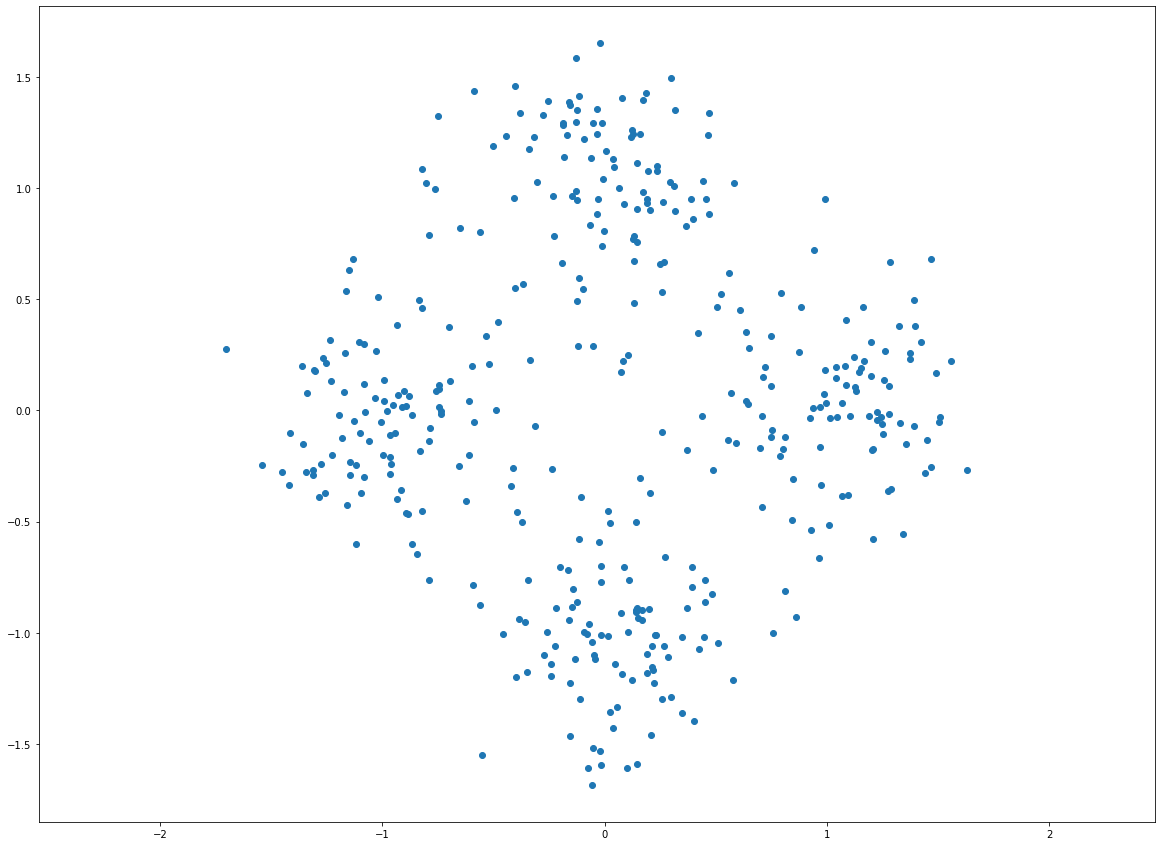

In [51]:
# Generate random data points for clustering

# Cluster 1
mean1 = [-1, 0]
cov1 = [[0.1, 0], [0, 0.1]]
X1 = np.random.multivariate_normal(mean1, cov1, 100)

# Cluster 2
mean2 = [0, 1]
cov2 = [[0.1, 0], [0, 0.1]]
X2 = np.random.multivariate_normal(mean2, cov2, 100)

# Cluster 3
mean3 = [1, 0]
cov3 = [[0.1, 0], [0, 0.1]]
X3 = np.random.multivariate_normal(mean3, cov3, 100)

# Cluster 4
mean4 = [0, -1]
cov4 = [[0.1, 0], [0, 0.1]]
X4 = np.random.multivariate_normal(mean4, cov4, 100)

# Merge sets of data points
X = np.concatenate((X1, X2, X3, X4))

# Plot data points
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

### 1.1 K-Means Clustering (1.5 points)
As discussed in the lecture, K-Means is one of the most popular clustering algorithms. You have been provided skeleton code for K-Means clustering in the file `segmentation.py`. Your first task is to finish implementing **`kmeans`** in `segmentation.py`. This naive version uses nested-for-loops to assign points to the closest centroid and compute new mean of each cluster.

kmeans running time: 0.619816 seconds.


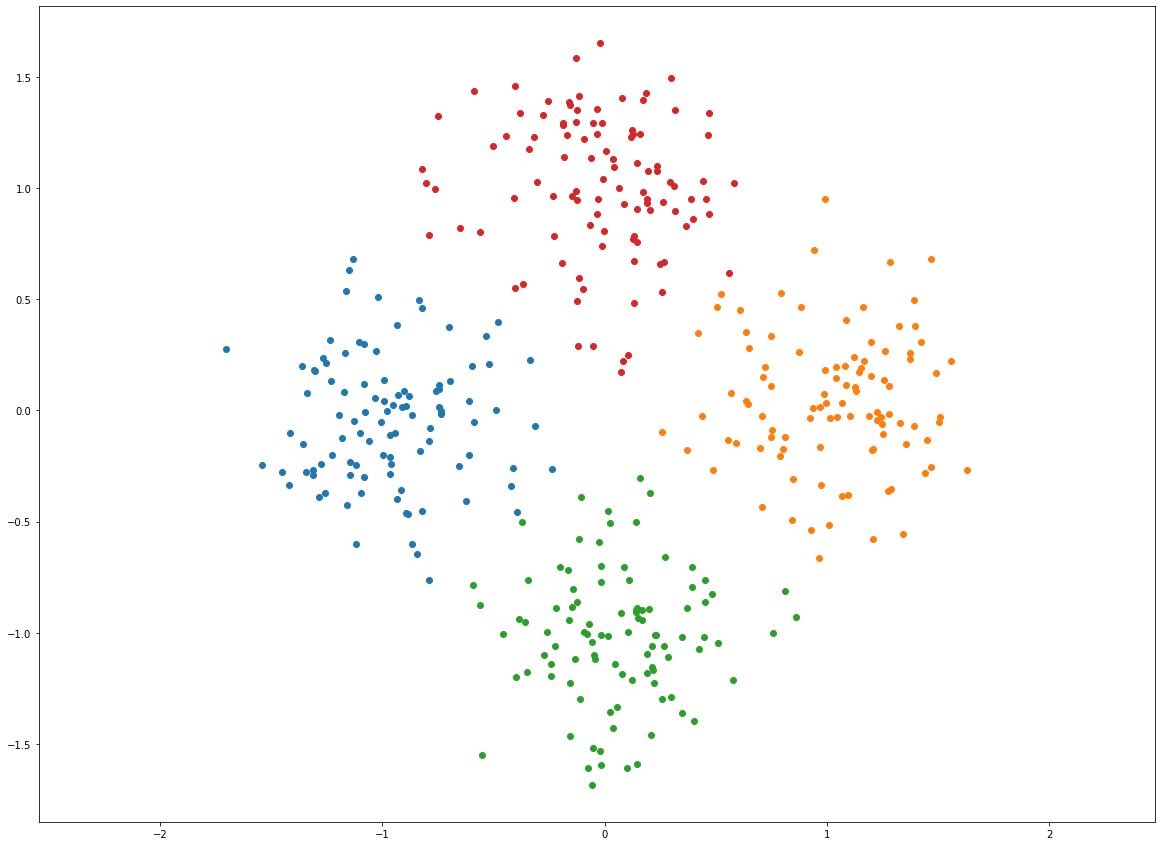

In [56]:
np.random.seed(0)
start = time()
assignments = kmeans(X, 4)
end = time()

kmeans_runtime = end - start

print("kmeans running time: %f seconds." % kmeans_runtime)

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

### 1.2 Fast K-Means Clustering (1.5 points)
We can use vectorization and broadcasting with numpy functions to make kmeans faster. Implement **`kmeans_fast`** in `segmentation.py`. This should run around 10 times faster than the previous implementation of the simple loop version.

kmeans running time: 0.016485 seconds.
37.599375 times faster!


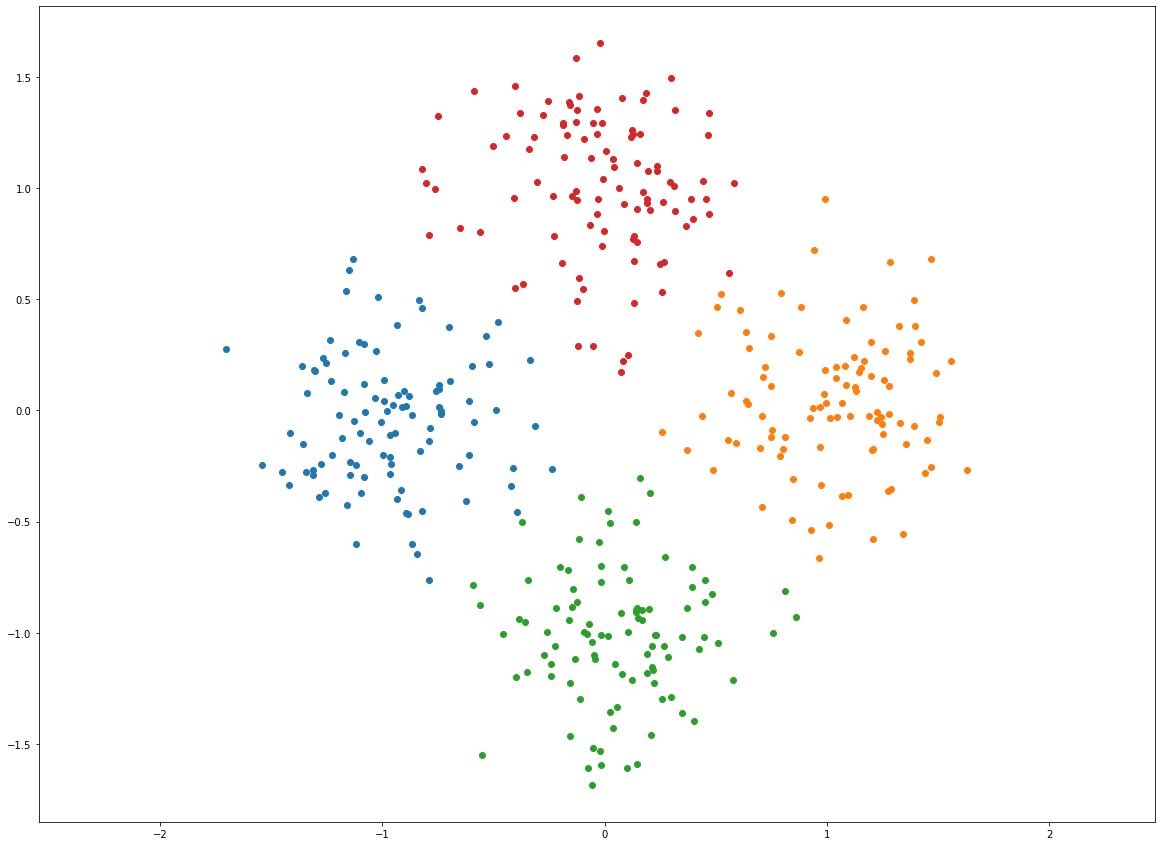

In [58]:
np.random.seed(0)
start = time()
assignments = kmeans_fast(X, 4)
end = time()

kmeans_fast_runtime = end - start
print("kmeans running time: %f seconds." % kmeans_fast_runtime)
print("%f times faster!" % (kmeans_runtime / kmeans_fast_runtime))

for i in range(4):
    cluster_i = X[assignments==i]
    plt.scatter(cluster_i[:, 0], cluster_i[:, 1])

plt.axis('equal')
plt.show()

## Part 2: Pixel-Level Features (1.5 points)
Before we can use a clustering algorithm to segment an image, we must compute some *feature vectore* for each pixel. The feature vector for each pixel should encode the qualities that we care about in a good segmentation. More concretely, for a pair of pixels $p_i$ and $p_j$ with corresponding feature vectors $f_i$ and $f_j$, the distance between $f_i$ and $f_j$ should be small if we believe that $p_i$ and $p_j$ should be placed in the same segment and large otherwise.

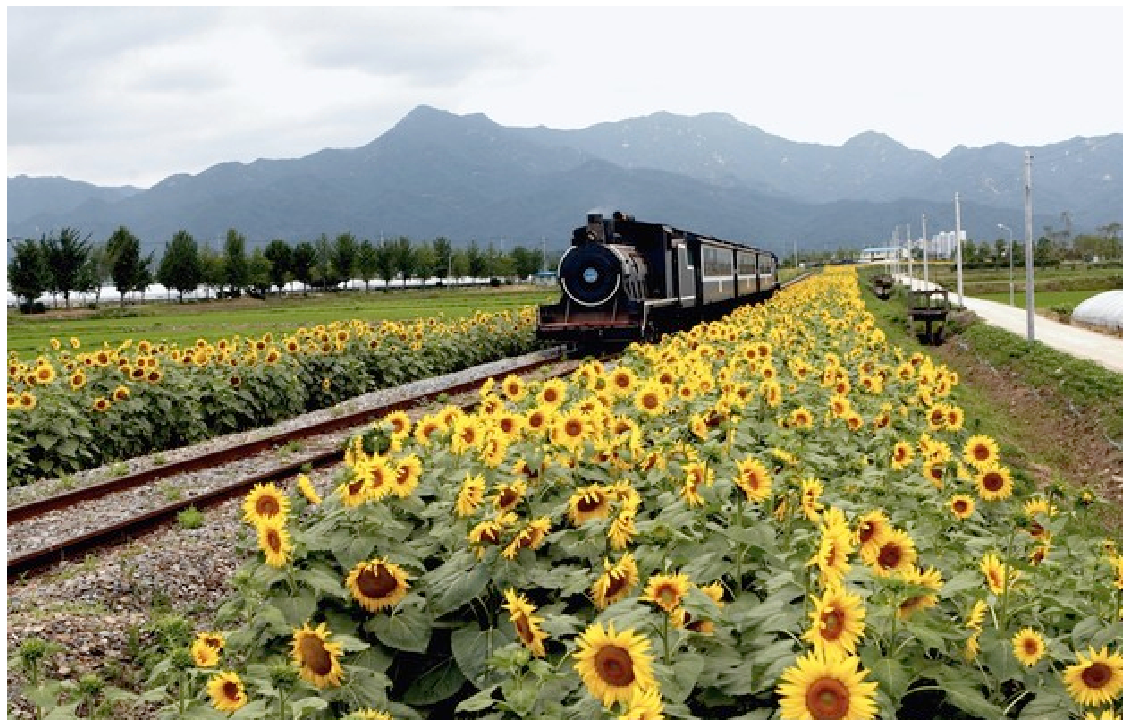

In [59]:
# Load and display image
img = io.imread('train.jpg')
H, W, C = img.shape

plt.imshow(img)
plt.axis('off')
plt.show()

### 2.1 Color Features (0.5 point)
One of the simplest possible feature vectors for a pixel is simply the vector of colors for that pixel. Implement **`color_features`** in `segmentation.py`. Output should look like the following:
![color_features.png](attachment:color_features.png)

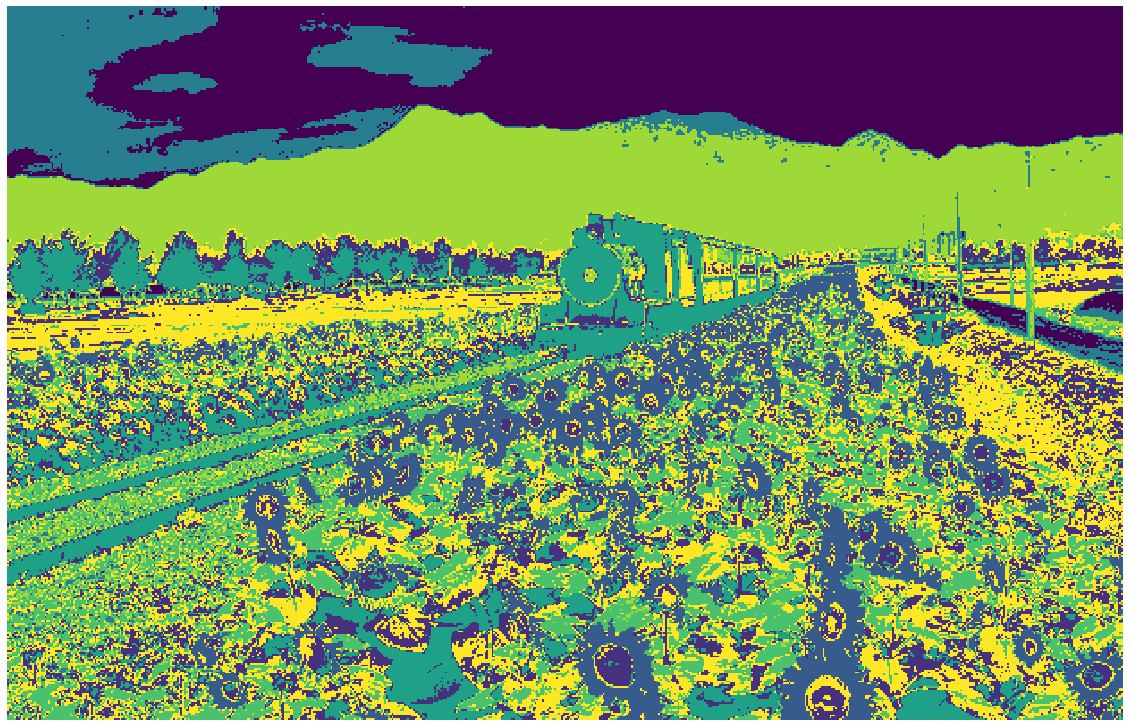

In [61]:
np.random.seed(0)

features = color_features(img)

# Sanity checks
assert features.shape == (H * W, C),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

In the cell below, we visualize each segment as the mean color of pixels in the segment.

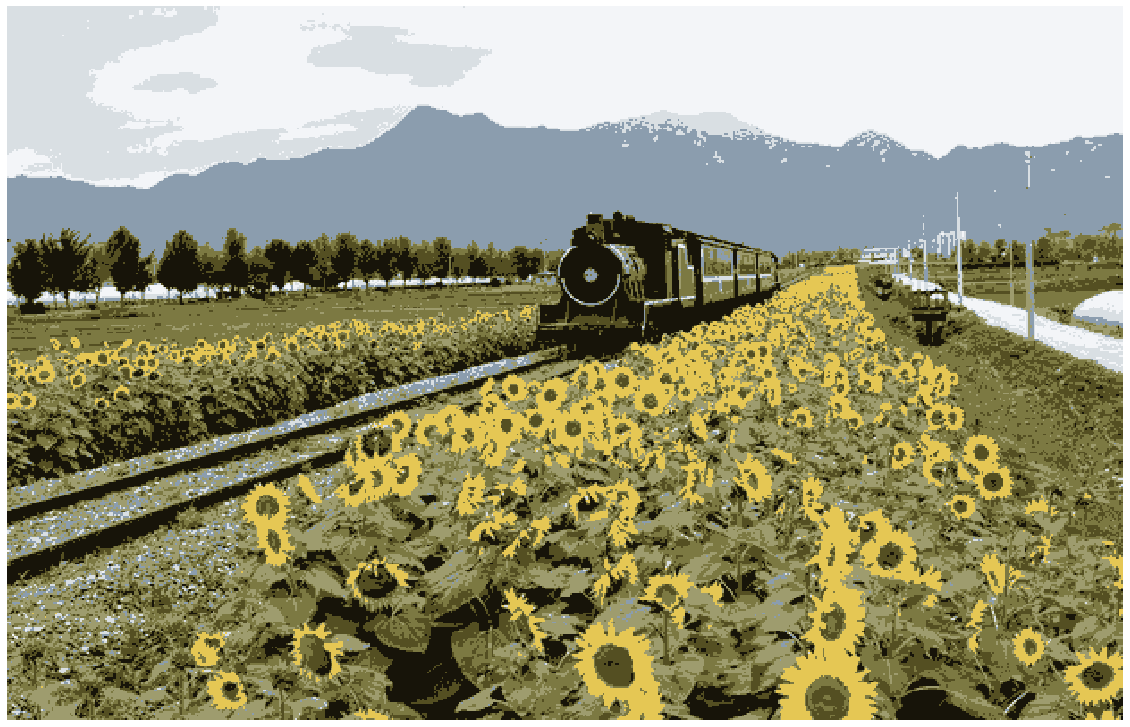

In [62]:
from utils import visualize_mean_color_image
visualize_mean_color_image(img, segments)

### 2.2 Color and Position Features (0.5 point)
Another simple feature vector for a pixel is to concatenate its color and position within the image. In other words, for a pixel of color $(r, g, b)$ located at position $(x, y)$ in the image, its feature vector would be $(r, g, b, x, y)$. However, the color and position features may have drastically different ranges; for example each color channel of an image may be in the range $[0, 1)$, while the position of each pixel may have a much wider range. Uneven scaling between different features in the feature vector may cause clustering algorithms to behave poorly.

One way to correct for uneven scaling between different features is to apply some sort of normalization to the feature vector. One of the simplest types of normalization is to force each feature to have zero mean and unit variance.

Implement **`color_position_features`** in `segmentation.py`.

Output segmentation should look like the following:
![color_position_features.png](attachment:color_position_features.png)

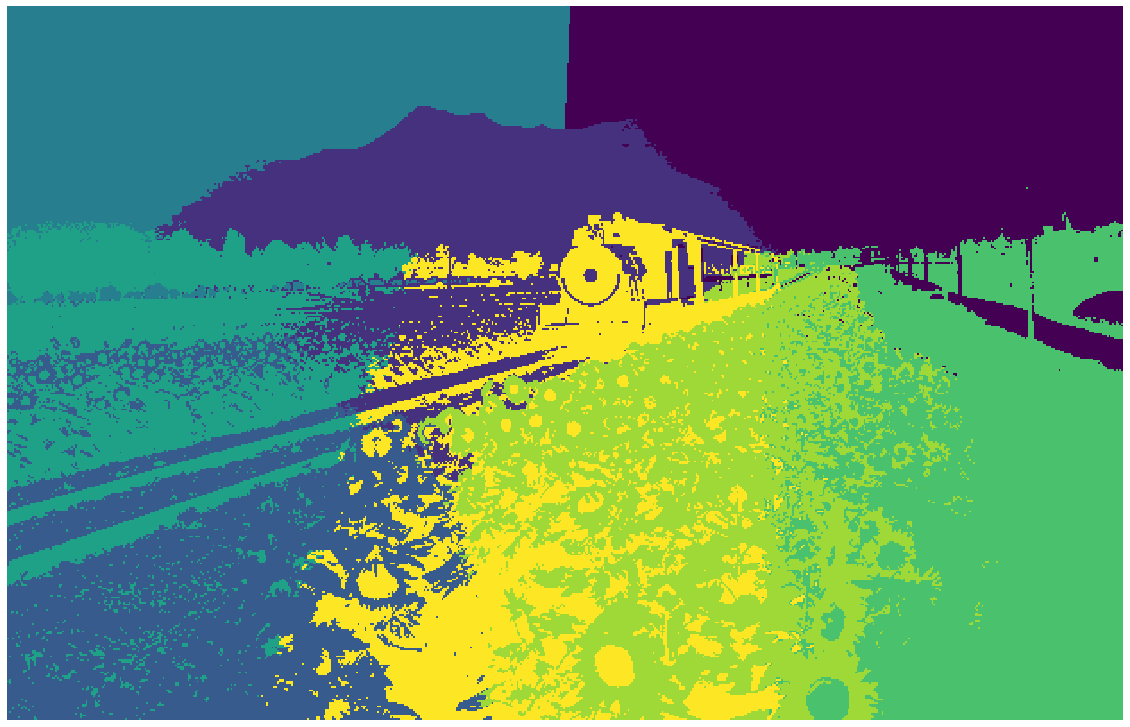

In [64]:
np.random.seed(0)

features = color_position_features(img)

# Sanity checks
assert features.shape == (H * W, C + 2),\
    "Incorrect shape! Check your implementation."

assert features.dtype == np.float,\
    "dtype of color_features should be float."

assignments = kmeans_fast(features, 8)
segments = assignments.reshape((H, W))

# Display segmentation
plt.imshow(segments, cmap='viridis')
plt.axis('off')
plt.show()

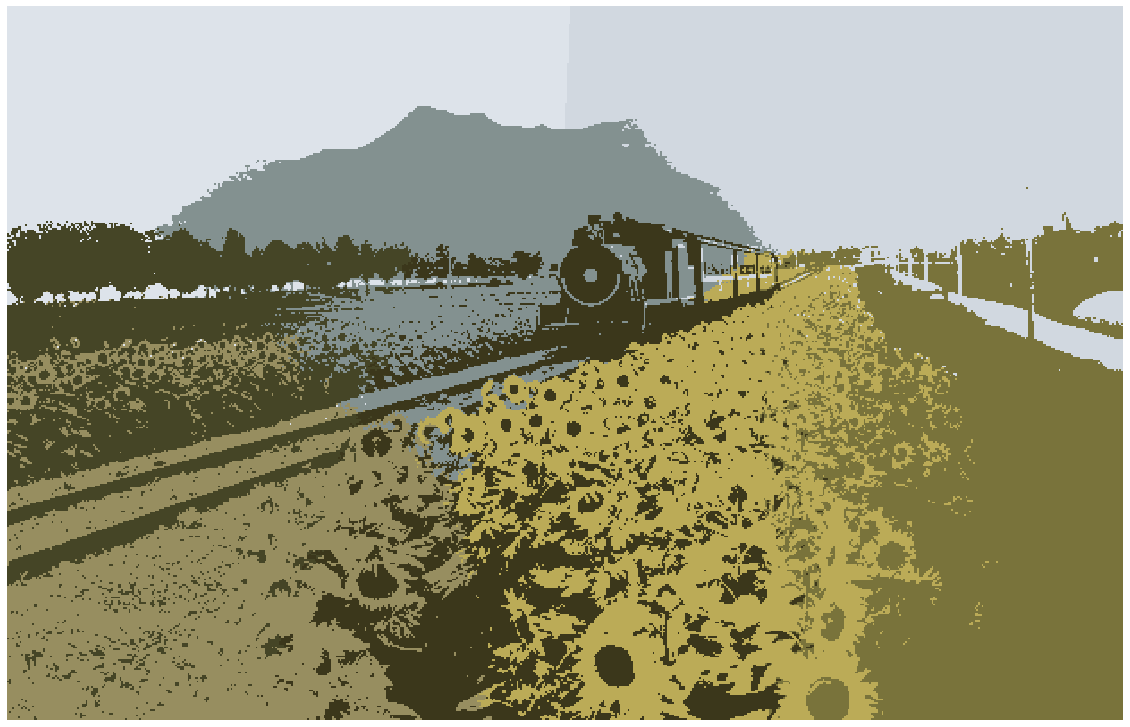

In [65]:
visualize_mean_color_image(img, segments)

## Part 3: Quantitative Evaluation (1 point)

Looking at images is a good way to get an idea for how well an algorithm is working, but the best way to evaluate an algorithm is to have some quantitative measure of its performance.

For this assignment, you were supplied with a small dataset of cat images and ground truth segmentations of these images into foreground (cats) and background (everything else). We will quantitatively evaluate different segmentation methods (features and clustering parameters) on this dataset. Specifically, we need to separate an image into foreground and background regions. Accuracy is the fraction of pixels where the ground truth foreground-background segmentation agrees with the estimated foreground-background segmentation.

(**0.5 point**) Implement **`compute_accuracy`** in `segmentation.py`.

Accuracy: 0.97


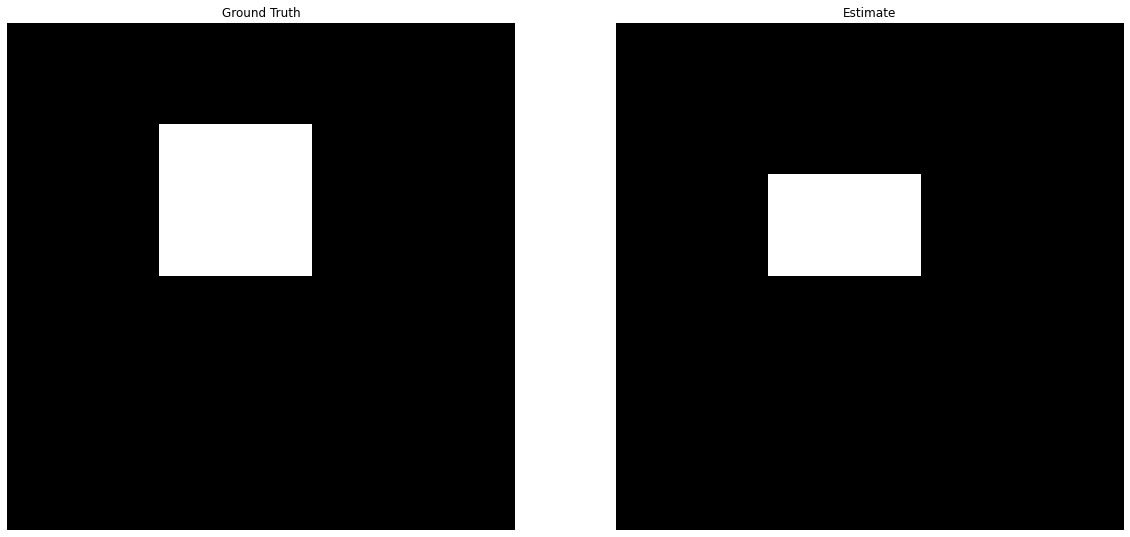

In [67]:
mask_gt = np.zeros((100, 100))
mask = np.zeros((100, 100))

# Test compute_accracy function
mask_gt[20:50, 30:60] = 1
mask[30:50, 30:60] = 1

accuracy = compute_accuracy(mask_gt, mask)

print('Accuracy: %0.2f' % (accuracy))
if accuracy != 0.97:
    print('Check your implementation!')

plt.subplot(121)
plt.imshow(mask_gt)
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(122)
plt.imshow(mask)
plt.title('Estimate')
plt.axis('off')

plt.show()

You can use the script below to evaluate a segmentation method’s ability to separate foreground from background on the entire provided dataset. Use this script as a starting point to evaluate a variety of segmentation parameters.

In [68]:
from utils import load_dataset, compute_segmentation

# Load a small segmentation dataset
imgs, gt_masks = load_dataset('./data')

# Set the parameters for segmentation (you may need to change these parameters for evaluating the segmentation performance).
num_segments = 3
clustering_fn = kmeans_fast
feature_fn = color_features
scale = 0.5

mean_accuracy = 0.0

segmentations = []

for i, (img, gt_mask) in enumerate(zip(imgs, gt_masks)):
    # Compute a segmentation for this image
    segments = compute_segmentation(img, num_segments,
                                    clustering_fn=clustering_fn,
                                    feature_fn=feature_fn,
                                    scale=scale)
    
    segmentations.append(segments)
    
    # Evaluate segmentation
    accuracy = evaluate_segmentation(gt_mask, segments)
    
    print('Accuracy for image %d: %0.4f' %(i, accuracy))
    mean_accuracy += accuracy
    
mean_accuracy = mean_accuracy / len(imgs)
print('Mean accuracy: %0.4f' % mean_accuracy)

Accuracy for image 0: 0.8079
Accuracy for image 1: 0.9583
Accuracy for image 2: 0.9643
Accuracy for image 3: 0.9060
Accuracy for image 4: 0.9623
Accuracy for image 5: 0.6851
Accuracy for image 6: 0.6734
Accuracy for image 7: 0.6688
Accuracy for image 8: 0.8366
Accuracy for image 9: 0.9517
Accuracy for image 10: 0.8562
Accuracy for image 11: 0.8113
Accuracy for image 12: 0.7310
Accuracy for image 13: 0.6618
Accuracy for image 14: 0.7450
Accuracy for image 15: 0.4931
Mean accuracy: 0.7946


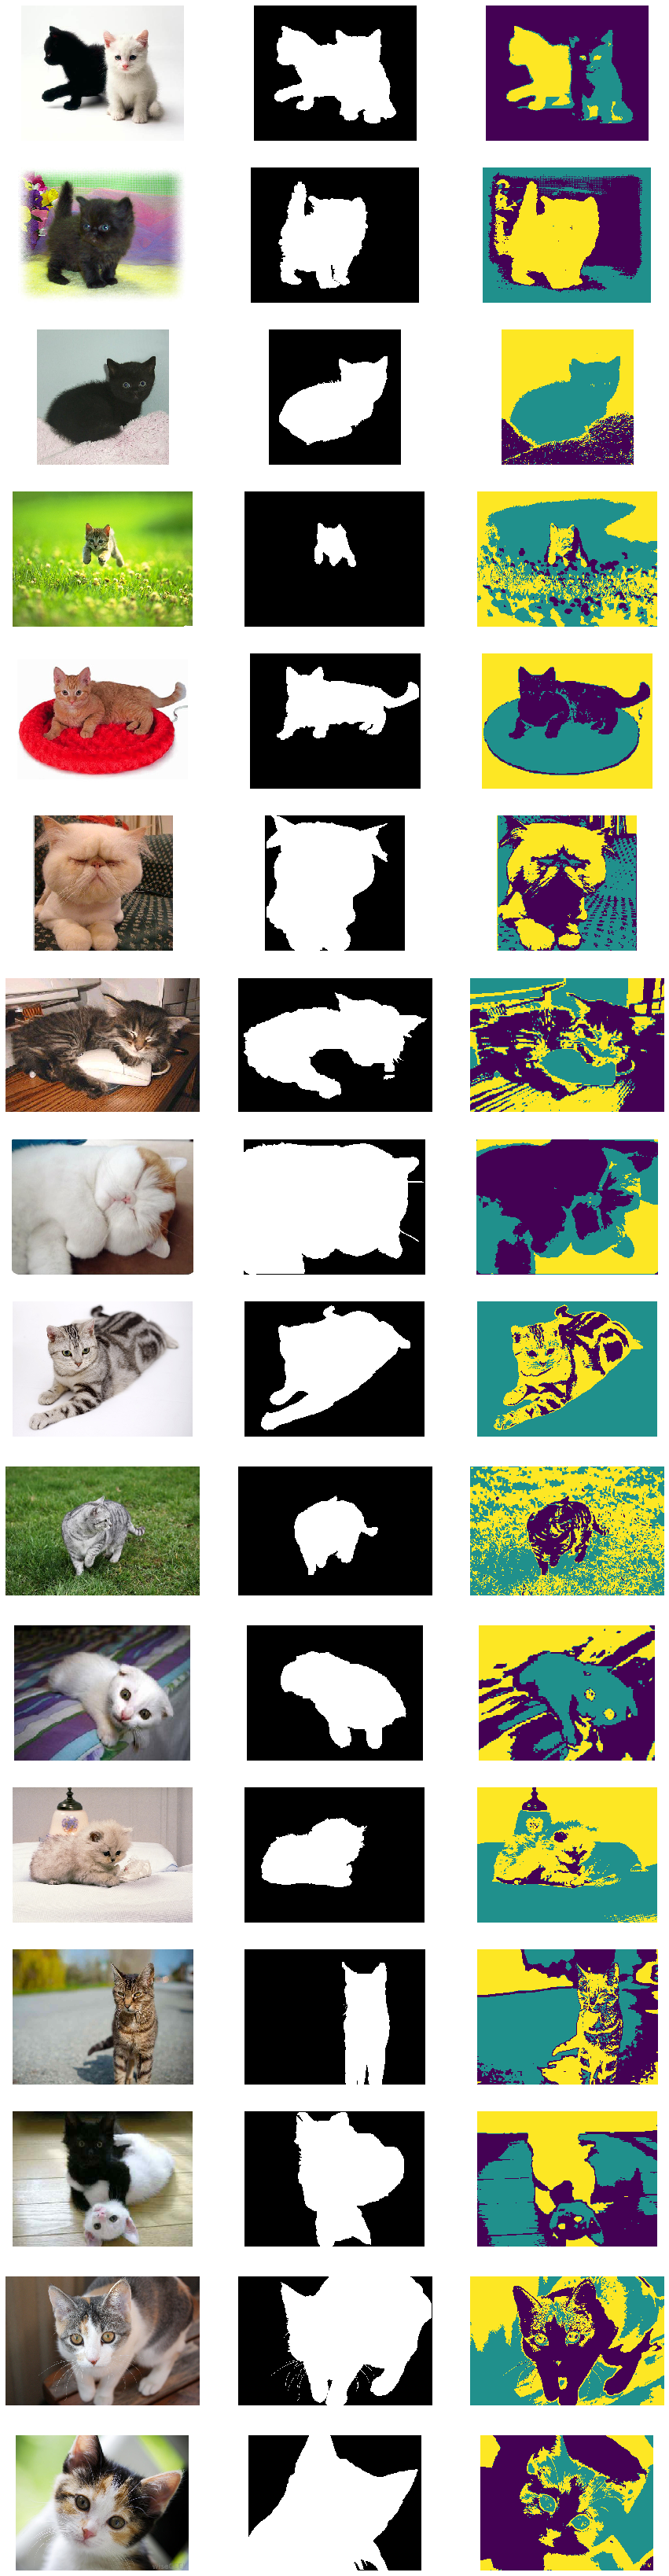

In [69]:
# Visualize segmentation results

N = len(imgs)
plt.figure(figsize=(15,60))
for i in range(N):

    plt.subplot(N, 3, (i * 3) + 1)
    plt.imshow(imgs[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 2)
    plt.imshow(gt_masks[i])
    plt.axis('off')

    plt.subplot(N, 3, (i * 3) + 3)
    plt.imshow(segmentations[i], cmap='viridis')
    plt.axis('off')

plt.show()

Include a detailed evaluation of the effect of varying segmentation parameters, i.e., feature type (color or color+position), number of clusters, and scale on the mean accuracy of foreground-background segmentations on the provided dataset. You should test a minimum of 5 combinations of parameters. To present your results, add rows to the table below (you may delete the first row, which is just an example).

 <table style="width:100%">
  <tr>
    <th>Feature Type</th>
    <th>Number of segments</th>
    <th>Scale</th>
    <th>Mean Accuracy</th>
  </tr>
  <tr>
    <td>Color</td>
    <td>3</td>
    <td>0.5</td>
    <td>0.58</td>
  </tr>
   <tr>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
    <td>...</td>
  </tr>
</table> 

(**0.5 point**) Observe your results carefully and try to answer the following question:
1. Based on your quantitative experiments, how do each of the segmentation parameters affect the quality of the final foreground-background segmentation?
2. Are some images simply more difficult to segment correctly than others? If so, what are the qualities of these images that cause the segmentation algorithms to perform poorly?
3. Also feel free to point out or discuss any other interesting observations that you made.

Write your analysis in the cell below.

**Your answer here**:...

**Credit**: Juan Carlos Niebles and Ranjay Krishna